In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import numpy as np
# ---- 한글 폰트 설정 ----
# (Windows) 보통 'Malgun Gothic'
plt.rc('font', family='Malgun Gothic')  
# (Mac) 보통 'AppleGothic'
# plt.rc('font', family='AppleGothic')
# (Linux, Colab) 나눔글꼴 경로 지정 필요할 수 있음
# plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# sliding 데이터 불러오기

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="Malgun Gothic")

df = pd.read_csv("../data/processed/train_sliding_sales.csv", encoding="utf-8")
df_new = pd.read_csv("../data/processed/test_sliding_sales.csv", encoding="utf-8")



In [95]:
df_new.shape

(11772, 111)

- nan 발견됨, 일단 행을 제거

# Mixture of Expert(MoE)

In [96]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


In [97]:
print(df['market_adj'].unique())


['뚝섬' '마장동' '답십리' '성수' '기타' '왕십리' '금남시장' '한양대' '장한평자동차' '옥수' '신금호' '행당']


## 1. 데이터 준비

In [98]:
import pandas as pd
import numpy as np
from typing import Tuple, List

# --- 규칙(필요 시 외부에서 주입 가능) ---
MUST_KEEP = ["biz_type_adj", "market_adj", "is_franchise", "is_cold_start"]

EXCLUDE_EXACT = {
    "biz_type", "market", "base_ym", "y", "open", "cluster",
}

EXCLUDE_PREFIXES = [
    "sales_",
    "rel_",
    "share_",
    "sales_rank_",
    "sales_estimate",
    "M1_SME_RY",
    "txn_cnt",
    "cust_cnt"
]


# =========================================================
# 1️⃣ 피처 선택 (missing 관련 변수 완전 제거)
# =========================================================
def select_features_only(
    df: pd.DataFrame,
    must_keep: List[str] = None,
    exclude_exact: set = None,
    exclude_prefixes: List[str] = None,
) -> pd.DataFrame:
    """
    입력 df를 규칙에 따라 필터링하여 df_final 반환.
    - *_missing* 관련 컬럼은 전부 제외함
    """
    must_keep = MUST_KEEP if must_keep is None else must_keep
    exclude_exact = EXCLUDE_EXACT if exclude_exact is None else exclude_exact
    exclude_prefixes = EXCLUDE_PREFIXES if exclude_prefixes is None else exclude_prefixes

    feat_cols = []
    for c in df.columns:
        # 1. 화이트리스트면 무조건 포함
        if c in must_keep:
            feat_cols.append(c)
            continue
        # 2. 정확 일치 제외
        if c in exclude_exact:
            continue
        # 3. 접두사 제외
        if any(c.startswith(p) for p in exclude_prefixes):
            continue
        # 4. missing 관련 제외
        if "missing" in c.lower():
            continue
        # 5. 나머지 포함
        feat_cols.append(c)

    df_final = df[feat_cols].copy()

    # sanity check
    for col in must_keep:
        assert col in df_final.columns, f"{col} 이(가) 누락되었습니다."

    return df_final


# =========================================================
# 2️⃣ X, Z 컬럼 자동 생성
# =========================================================
def make_XZ_cols(df_final: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    df_final에서 MoE용 X_cols, Z_cols 생성.
    - X_cols: 수치 피처
    - Z_cols: 업종/상권/가맹/콜드스타트
    """
    X_cols = [
        c for c in df_final.columns
        if c not in MUST_KEEP
        and c not in {"num", "target_ym"}
    ]
    Z_cols = ["biz_type_adj", "market_adj", "is_franchise", "is_cold_start"]
    return X_cols, Z_cols


# =========================================================
# 3️⃣ 타입 정리
# =========================================================
def coerce_types_for_XZ(
    df_final: pd.DataFrame,
    X_cols: List[str],
    Z_cols: List[str],
) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    모델 입력 전 최소 타입 정리
    """
    # X는 전부 numeric 변환
    X = df_final[X_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).values

    # Z는 문자열 2개, 숫자 2개
    Z = df_final[Z_cols].copy()
    if "biz_type_adj" in Z:
        Z["biz_type_adj"] = Z["biz_type_adj"].astype("string").fillna("__NA__")
    if "market_adj" in Z:
        Z["market_adj"] = Z["market_adj"].astype("string").fillna("__NA__")
    if "is_franchise" in Z:
        Z["is_franchise"] = pd.to_numeric(Z["is_franchise"], errors="coerce").fillna(0).astype(float)
    if "is_cold_start" in Z:
        Z["is_cold_start"] = pd.to_numeric(Z["is_cold_start"], errors="coerce").fillna(0).astype(float)

    return X, Z


## 2. 데이터 분리 (Expert X, Gate Z)

In [99]:
# 1. 전처리
df_final = select_features_only(df)

# 2. X/Z 컬럼 분리
X_cols, Z_cols = make_XZ_cols(df_final)

# 3. 타입 정리
X, Z = coerce_types_for_XZ(df_final, X_cols, Z_cols)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
Z_enc = enc.fit_transform(Z)

In [100]:
print(list(df_final.columns))

['num', 'is_franchise', 'is_cold_start', 'biz_type_adj', 'market_adj', 'target_ym', 'oper_month_grp_mean', 'avg_pay_grp_mean', 'cancel_rate_grp_mean', 'delivery_sales_ratio_mean', 'male_20below_ratio_mean', 'male_30_ratio_mean', 'male_40_ratio_mean', 'male_50_ratio_mean', 'male_60plus_ratio_mean', 'female_20below_ratio_mean', 'female_30_ratio_mean', 'female_40_ratio_mean', 'female_50_ratio_mean', 'female_60plus_ratio_mean', 'revisit_ratio_mean', 'new_ratio_mean', 'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean', 'oper_month_grp_std', 'avg_pay_grp_std', 'cancel_rate_grp_std', 'delivery_sales_ratio_std', 'male_20below_ratio_std', 'male_30_ratio_std', 'male_40_ratio_std', 'male_50_ratio_std', 'male_60plus_ratio_std', 'female_20below_ratio_std', 'female_30_ratio_std', 'female_40_ratio_std', 'female_50_ratio_std', 'female_60plus_ratio_std', 'revisit_ratio_std', 'new_ratio_std', 'resident_ratio_std', 'worker_ratio_std', 'floating_ratio_std', 'oper_month_grp_last', 'avg_pay_g

## 3: Expert Model (GMM)

### 3-1 best k 찾기

In [101]:
X.shape

(40856, 57)

In [102]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1️⃣ 후보 k별 BIC 계산
# ------------------------------
bic_scores = {}
for k in range(3, 13):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        n_init=5,
        random_state=42,
        reg_covar=1e-6
    ).fit(X)
    bic_scores[k] = gmm.bic(X)

# ------------------------------
# 2️⃣ 최적 k 선택 및 시각화
# ------------------------------
best_k = min(bic_scores, key=bic_scores.get)

c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [103]:
bic_scores

{3: 6164078.252340945,
 4: 5297764.318310567,
 5: 4938928.911747465,
 6: 4707620.593021991,
 7: 4452287.247683444,
 8: 4304600.57586232,
 9: 4276867.882705569,
 10: 4052949.689506044,
 11: 3981876.762794312,
 12: 3899600.520333312}

In [104]:
best_k

12

In [105]:
#best_k 입력하기
#best_k = 9   # choose via BIC/AIC

### 3-2 best_k애 맞게 GMM 돌리기

In [106]:
# Gaussian Mixture (expert part)

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    n_init=5,
    random_state=42,
    reg_covar=1e-6
)
gmm.fit(X)

# 각 점포의 soft cluster 확률
cluster_proba = gmm.predict_proba(X)
df_final["gmm_cluster"] = gmm.predict(X)


## 4. Gate Model (업종/상권/프랜차이즈/cold start/missing별 Cluster 확률 예측)

In [107]:
# Gate model: 업종/상권 → cluster soft assignment
gate = LogisticRegression(
    multi_class='multinomial',
    max_iter=500,
    random_state=42
)

# Gate 학습
gate.fit(Z_enc, np.argmax(cluster_proba, axis=1))

# 조건별로 cluster 확률 추정
gate_proba = gate.predict_proba(Z_enc)


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [108]:
K = cluster_proba.shape[1]

In [109]:
import numpy as np

# gate_proba: (n_samples, K) 하지만 열 순서가 gate.classes_ 기준
gate_proba_raw = gate.predict_proba(Z_enc)

# 열 재정렬: gate.classes_ 를 0..K-1 순서로 매핑
order = np.argsort(gate.classes_)            # classes_가 [0,1,...,K-1] 이면 order는 [0,1,...,K-1]
gate_proba = gate_proba_raw[:, order]

# 안전 체크
assert gate_proba.shape == cluster_proba.shape, "Gate/GMM 확률 shape 불일치"


## 5. Conditional MoE 확률 계산

In [110]:
# 소프트 결합 & 정규화
moe_cluster_proba = cluster_proba * gate_proba
row_sum = moe_cluster_proba.sum(axis=1, keepdims=True)
moe_cluster_proba = np.divide(moe_cluster_proba, row_sum, where=row_sum!=0)

# 최종 라벨
moe_cluster = moe_cluster_proba.argmax(axis=1)
df_final["moe_cluster"] = moe_cluster

# (옵션) 확률 컬럼도 보관
for k in range(K):
    df_final[f"moe_p_{k}"] = moe_cluster_proba[:, k]


## 6. 모델비교

In [111]:
print("GMM cluster distribution:")
print(df_final["gmm_cluster"].value_counts(normalize=True).round(3))

print("MoE cluster distribution:")
print(df_final["moe_cluster"].value_counts(normalize=True).round(3))

# Gate 모델의 fit 품질 (얼마나 잘 cluster를 조건으로 예측하는가)
pred_cluster = gate.predict(Z_enc)
print("Gate model log-loss:", log_loss(np.argmax(cluster_proba, axis=1), gate_proba))


GMM cluster distribution:
gmm_cluster
2     0.268
11    0.150
3     0.105
9     0.094
6     0.081
0     0.057
4     0.057
7     0.051
10    0.051
5     0.038
1     0.026
8     0.021
Name: proportion, dtype: float64
MoE cluster distribution:
moe_cluster
2     0.269
11    0.150
3     0.105
9     0.094
6     0.081
0     0.057
4     0.056
10    0.051
7     0.051
5     0.038
1     0.026
8     0.021
Name: proportion, dtype: float64
Gate model log-loss: 1.8711853274437813


## 7. 모델해석, 프로파일

In [112]:
# 군집별 주요 피처 평균
profile = df_final.groupby("moe_cluster")[X_cols].mean().round(2)
print(profile.T)


moe_cluster                   0      1      2      3      4      5      6   \
oper_month_grp_mean         3.06   4.09   3.18   3.09   4.54   3.25   3.65   
avg_pay_grp_mean            3.64   4.33   3.35   3.27   3.29   4.46   3.23   
cancel_rate_grp_mean        1.12   1.23   2.25   2.16   1.92   1.87   1.82   
delivery_sales_ratio_mean   0.00   0.00   0.00  24.73   0.00   0.00   0.00   
male_20below_ratio_mean     0.00   7.69  15.51  10.69  18.80   2.67  10.35   
male_30_ratio_mean          5.81  11.40  15.45  14.87  14.08   5.81  13.79   
male_40_ratio_mean         10.51  10.05  10.07  13.13   4.95   7.75  10.55   
male_50_ratio_mean         16.92   9.67   9.72  13.61   3.60   9.13  12.51   
male_60plus_ratio_mean     22.55   9.94   6.22   9.06   1.28  10.72  11.34   
female_20below_ratio_mean   0.00   8.23  13.11   6.54  25.67   3.66   8.47   
female_30_ratio_mean        4.84  10.37  11.97   9.22  18.78   9.12  10.05   
female_40_ratio_mean        6.86   7.47   7.25   8.30   6.43  12

- 🧩 8️⃣ Step 6: 위험 탐지 모델에 활용

이제 df_final["moe_cluster"]를 feature로 넣어

폐업여부, y_next_rank 등의 타깃을 예측할 때
군집별 상이한 risk pattern을 반영할 수 있습니다.

## 8. 업종, 상권 vs 군집 heatmap

### 8-1. 업종 군집

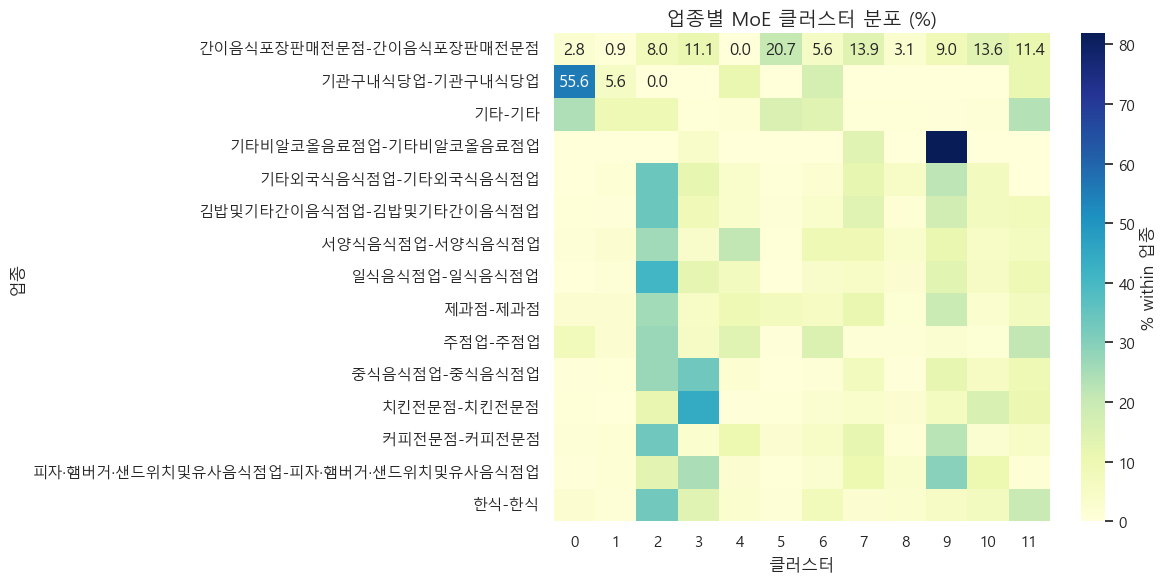

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 업종별 군집 분포 (%)
pivot_biz = (
    df_final.groupby(["biz_type_adj", "moe_cluster"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_biz,
    annot=True, fmt=".1f", cmap="YlGnBu",
    cbar_kws={"label": "% within 업종"}
)
plt.title("업종별 MoE 클러스터 분포 (%)", fontsize=14)
plt.xlabel("클러스터")
plt.ylabel("업종")
plt.tight_layout()
plt.show()


### 8-2 상권군집

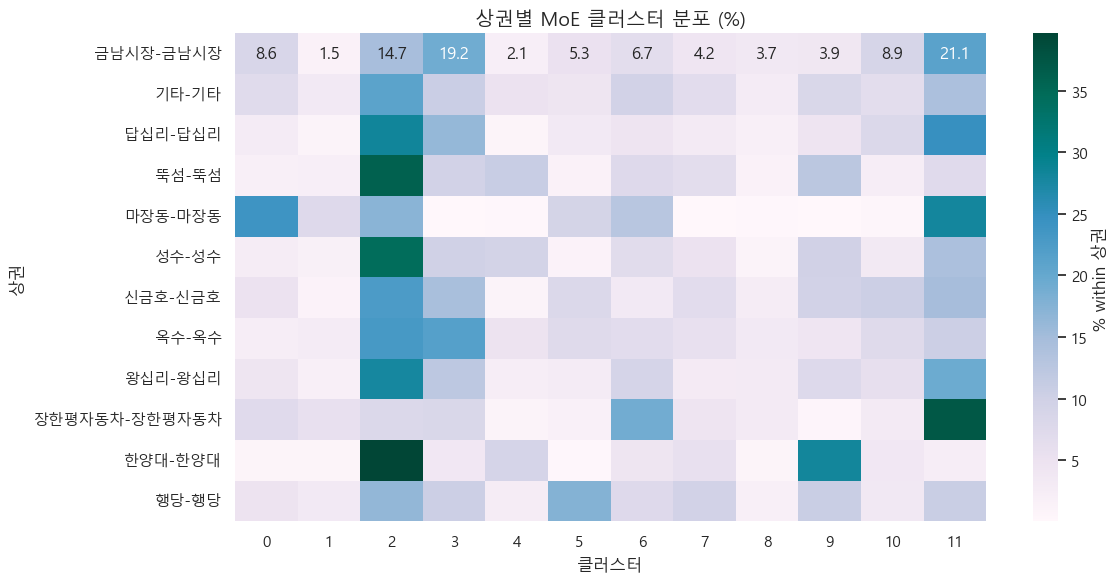

In [114]:
pivot_market = (
    df_final.groupby(["market_adj", "moe_cluster"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_market,
    annot=True, fmt=".1f", cmap="PuBuGn",
    cbar_kws={"label": "% within 상권"}
)
plt.title("상권별 MoE 클러스터 분포 (%)", fontsize=14)
plt.xlabel("클러스터")
plt.ylabel("상권")
plt.tight_layout()
plt.show()


### 8-3 집계표 요약

In [115]:
summary = (
    df_final.groupby(["biz_type_adj", "market_adj", "moe_cluster"])
    .size()
    .reset_index(name="count")
)

# 업종 내 비율 계산
summary["prop_in_biz"] = (
    summary.groupby("biz_type_adj")["count"]
    .transform(lambda x: x / x.sum() * 100)
)

summary.sort_values(["biz_type_adj", "prop_in_biz"], ascending=[True, False]).head(20)


,biz_type_adj,market_adj,moe_cluster,count,prop_in_biz
33,간이음식포장판매전문점,한양대,9,24,7.407407
6,간이음식포장판매전문점,기타,5,22,6.790123
36,간이음식포장판매전문점,행당,7,22,6.790123
0,간이음식포장판매전문점,금남시장,3,20,6.172840
11,간이음식포장판매전문점,기타,10,16,4.938272
4,간이음식포장판매전문점,기타,2,14,4.320988
8,간이음식포장판매전문점,기타,7,13,4.012346
13,간이음식포장판매전문점,뚝섬,2,12,3.703704
20,간이음식포장판매전문점,뚝섬,10,12,3.703704
24,간이음식포장판매전문점,신금호,5,12,3.703704


### 8-4 군집전이 확률

In [116]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num                        40856 non-null  object 
 1   is_franchise               40856 non-null  int64  
 2   is_cold_start              40856 non-null  int64  
 3   biz_type_adj               40856 non-null  object 
 4   market_adj                 40856 non-null  object 
 5   target_ym                  40856 non-null  object 
 6   oper_month_grp_mean        40856 non-null  float64
 7   avg_pay_grp_mean           40856 non-null  float64
 8   cancel_rate_grp_mean       40856 non-null  float64
 9   delivery_sales_ratio_mean  40856 non-null  float64
 10  male_20below_ratio_mean    40856 non-null  float64
 11  male_30_ratio_mean         40856 non-null  float64
 12  male_40_ratio_mean         40856 non-null  float64
 13  male_50_ratio_mean         40856 non-null  flo

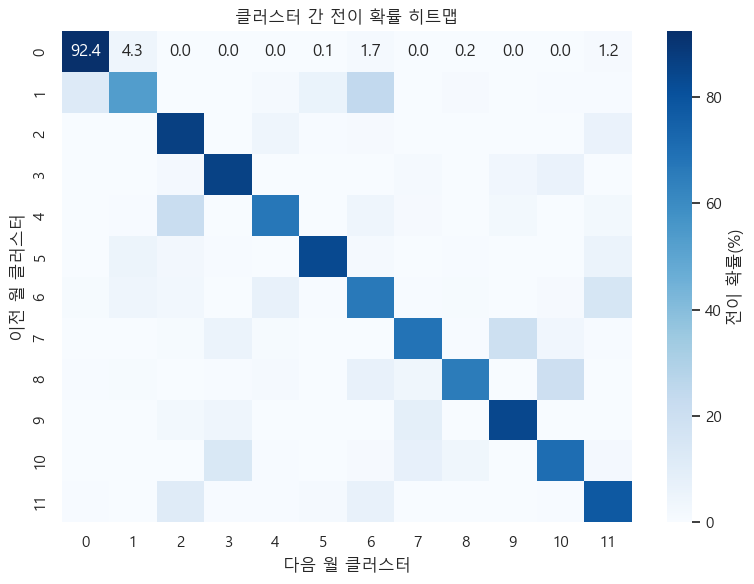

curr,0,1,2,3,4,5,6,7,8,9,10,11
prev,,,,,,,,,,,,
0,0.924,0.043,0.000,0.000,0.000,0.001,0.017,0.000,0.002,0.000,0.000,0.012
1,0.122,0.533,0.000,0.000,0.017,0.058,0.244,0.001,0.014,0.000,0.005,0.006
2,0.000,0.000,0.869,0.003,0.042,0.004,0.011,0.002,0.000,0.003,0.002,0.063
3,0.000,0.000,0.019,0.860,0.000,0.000,0.000,0.018,0.002,0.035,0.063,0.003
4,0.000,0.006,0.218,0.002,0.669,0.002,0.040,0.014,0.001,0.023,0.002,0.023
5,0.003,0.052,0.027,0.006,0.001,0.834,0.015,0.003,0.004,0.000,0.000,0.055
6,0.010,0.040,0.030,0.000,0.069,0.007,0.666,0.004,0.008,0.000,0.013,0.153
7,0.000,0.000,0.008,0.057,0.008,0.003,0.000,0.683,0.006,0.197,0.034,0.004
8,0.007,0.008,0.000,0.004,0.017,0.003,0.072,0.038,0.654,0.000,0.199,0.000


In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df_ews: EWS 계산까지 완료된 DataFrame
# 반드시 ['num', 'base_ym', 'moe_cluster'] 포함
# base_ym은 YYYYMM 또는 datetime 형태여야 함

# 월 단위 정렬
df_seq = df_final.sort_values(['num', 'target_ym'])

# 군집 전이 정보 계산
transitions = []
for num, g in df_seq.groupby('num'):
    g = g.sort_values('target_ym')
    prev = g['moe_cluster'].shift(1)
    curr = g['moe_cluster']
    for p, c in zip(prev, curr):
        if pd.notna(p) and pd.notna(c):
            transitions.append((int(p), int(c)))

trans_df = pd.DataFrame(transitions, columns=['prev', 'curr'])

# 전이 행렬 계산
transition_matrix = (
    trans_df.value_counts()
    .unstack(fill_value=0)
    .div(trans_df['prev'].value_counts(), axis=0)
    .fillna(0)
    .round(3)
)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    transition_matrix * 100,
    cmap="Blues", annot=True, fmt=".1f",
    cbar_kws={'label': '전이 확률(%)'}
)
plt.title("클러스터 간 전이 확률 히트맵")
plt.xlabel("다음 월 클러스터")
plt.ylabel("이전 월 클러스터")
plt.tight_layout()
plt.show()

transition_matrix.head(12)


📊 전체 가맹점 수: 3,681
🔁 클러스터가 바뀐 가맹점 수: 2,629 (71.4%)
⚙️ 바뀌지 않은 가맹점 수: 1,052 (28.6%)


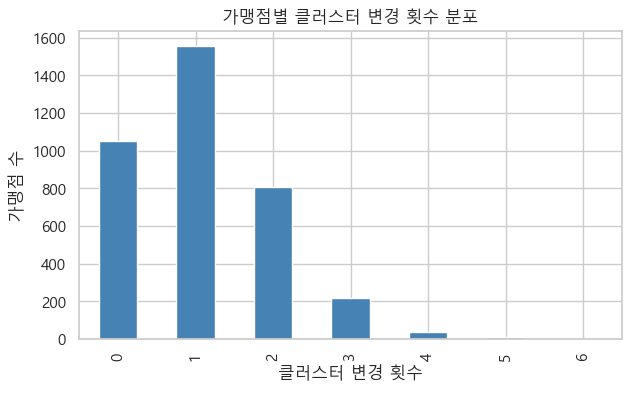

In [118]:
# 기준년월 정렬
df_final = df_final.sort_values(["num", "target_ym"])

# 가맹점별 클러스터 변화 여부 확인
cluster_change = (
    df_final.groupby("num")["moe_cluster"]
      .agg(["nunique", "count"])  # 각 점포의 고유 클러스터 수
      .rename(columns={"nunique": "고유클러스터수", "count": "관측개월"})
)

# 변경 횟수 = 고유 클러스터 수 - 1
cluster_change["클러스터_변경횟수"] = cluster_change["고유클러스터수"] - 1

# 변화 여부 flag
cluster_change["is_changed"] = (cluster_change["클러스터_변경횟수"] > 0).astype(int)

total_stores = cluster_change.shape[0]
changed_stores = cluster_change["is_changed"].sum()

print(f"📊 전체 가맹점 수: {total_stores:,}")
print(f"🔁 클러스터가 바뀐 가맹점 수: {changed_stores:,} ({changed_stores/total_stores*100:.1f}%)")
print(f"⚙️ 바뀌지 않은 가맹점 수: {total_stores - changed_stores:,} ({(1 - changed_stores/total_stores)*100:.1f}%)")

# --- 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
cluster_change["클러스터_변경횟수"].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("가맹점별 클러스터 변경 횟수 분포")
plt.xlabel("클러스터 변경 횟수")
plt.ylabel("가맹점 수")
plt.show()


# 9. 새로운 데이터 클러스터 배정

In [119]:
import numpy as np
import pandas as pd

def assign_moe_for_new_using_existing(
    df_new: pd.DataFrame,
    X_cols: list,              # 훈련 때 확정된 X_cols
    Z_cols: list,              # ["biz_type_adj","market_adj","is_franchise","is_cold_start"]
    enc, gmm, gate,            # 훈련된 OneHotEncoder / GMM / LogisticRegression
    id_cols=("num","target_ym"),
    add_proba: bool = True,
):
    """
    (1) 기존 전처리 규칙으로 df_new를 df_final_new로 정리
    (2) 기존 X_cols/Z_cols 순서로 맞춰 타입 보정
    (3) enc/gmm/gate로 MoE 확률 결합 → hard label + (옵션) 확률 반환
    """
    # 1) 동일 규칙 전처리
    df_final_new = select_features_only(df_new)

    # 2) X/Z 구성 (부족한 열은 0/NA로 생성하여 순서 맞춤) + 타입 보정
    #    - X_cols는 훈련 기준으로 고정: df_new에 없으면 0으로 생성
    for c in X_cols:
        if c not in df_final_new.columns:
            df_final_new[c] = 0
    #    - Z_cols도 고정: 없으면 임시 NA 생성 (coerce_types_for_XZ에서 처리)
    for c in Z_cols:
        if c not in df_final_new.columns:
            df_final_new[c] = np.nan

    X_new, Z_new = coerce_types_for_XZ(df_final_new, X_cols, Z_cols)

    # 3) 인코딩 & 확률 계산
    Z_enc_new = enc.transform(Z_new)               # 훈련 OneHotEncoder
    gmm_proba  = gmm.predict_proba(X_new)          # (n, K)

    gate_raw   = gate.predict_proba(Z_enc_new)     # (n, K) but classes_ order
    order      = np.argsort(gate.classes_)         # 0..K-1 순으로 재정렬
    gate_proba = gate_raw[:, order]

    moe = gmm_proba * gate_proba
    denom = moe.sum(axis=1, keepdims=True)
    np.divide(moe, denom, out=moe, where=(denom != 0))
    moe_label = moe.argmax(axis=1)

    # 4) 출력 정리
    out = pd.DataFrame({"moe_cluster": moe_label}, index=df_new.index)
    if add_proba:
        for k in range(moe.shape[1]):
            out[f"moe_p_{k}"] = moe[:, k]

    # id 컬럼 붙이기(있을 때만)
    for c in id_cols:
        if c in df_new.columns:
            out[c] = df_new[c].values

    cols = ["moe_cluster"] + [c for c in id_cols if c in out] + [c for c in out.columns if c.startswith("moe_p_")]
    return out[cols]


In [120]:
# 전제: 아래 3개는 이미 네가 가진 함수들
# select_features_only, make_XZ_cols, coerce_types_for_XZ

# 전제: 훈련 때 확정된 스펙/객체
# X_cols, Z_cols, enc, gmm, gate

assigned_new = assign_moe_for_new_using_existing(
    df_new,
    X_cols=X_cols,
    Z_cols=Z_cols,              # ["biz_type_adj","market_adj","is_franchise","is_cold_start"]
    enc=enc, gmm=gmm, gate=gate,
    id_cols=("num","target_ym"),
    add_proba=True
)
assigned_new.head()


,moe_cluster,num,target_ym,moe_p_0,moe_p_1,moe_p_2,moe_p_3,moe_p_4,moe_p_5,moe_p_6,moe_p_7,moe_p_8,moe_p_9,moe_p_10,moe_p_11
0,8,000F03E44A,2024-09-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,8,000F03E44A,2024-10-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,8,000F03E44A,2024-11-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,11,002816BA73,2024-09-01,0.0,2.844529e-46,9.273431e-23,1.937703e-41,2.668926e-154,9.172271e-152,5.901169e-16,4.239334e-104,3.519030e-50,0.000000e+00,1.346250e-22,1.000000
4,11,002816BA73,2024-10-01,0.0,1.738192e-46,8.010359e-06,3.810306e-24,7.546968e-138,5.466505e-120,8.565977e-17,2.591670e-68,1.272130e-50,4.122948e-194,3.078422e-23,0.999992


# 10.데이터 저장

In [121]:
import pandas as pd

# df에 클러스터만 병합
df_train_cluster = pd.merge(
    df,
    df_final[["num", "target_ym", "moe_cluster"]],
    on=["num", "target_ym"],
    how="left"
)

# CSV 저장
df_train_cluster.to_csv("../data/processed/train_cluster.csv", index=False, encoding="utf-8-sig")
print("✅ train_cluster.csv 저장 완료:", df_train_cluster.shape)


✅ train_cluster.csv 저장 완료: (40856, 112)


In [122]:
df_test_cluster = pd.merge(
    df_new,
    assigned_new[["num", "target_ym", "moe_cluster"]],
    on=["num", "target_ym"],
    how="left"
)

# CSV 저장
df_test_cluster.to_csv("../data/processed/test_cluster.csv", index=False, encoding="utf-8-sig")
print("✅ test_cluster.csv 저장 완료:", df_test_cluster.shape)

✅ test_cluster.csv 저장 완료: (11772, 112)


In [123]:

# 차이나는 열 찾기
diff_cols_1 = set(df_test_cluster.columns) - set(df_train_cluster.columns)  # df1에는 있지만 df2에는 없는 열
diff_cols_2 = set(df_train_cluster.columns) - set(df_test_cluster.columns)  # df2에는 있지만 df1에는 없는 열

print("test에만 있는 열:", diff_cols_1)
print("train에만 있는 열:", diff_cols_2)

test에만 있는 열: set()
train에만 있는 열: set()
